In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate as integrate
from matplotlib import gridspec
import scipy.signal
import healpy as hp
#import Corrfunc
from numba import jit
from scipy.stats import poisson, erlang
from scipy import interpolate
from os import urandom
import struct
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from matplotlib import gridspec
import seaborn as sns
from datetime import datetime
from scipy.special import factorial
from scipy.signal import savgol_filter
from scipy import integrate as integrate
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import optimize
from scipy import interpolate
from scipy.stats import norm
import math
import copy
import readfof
#import Corrfunc
#from Corrfunc.theory.xi import xi
from sklearn.neighbors import BallTree

plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc("text", usetex=True)
plt.rc("font", size=22)



In [4]:
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc("text", usetex=True)
plt.rc("font", size=22)

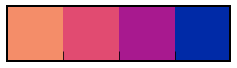

In [5]:
custom_cet = ["#f48d69","#e14b71","#a8198f","#002aa7"]
sns.palplot(custom_cet)

In [6]:
def cdf_vol_knn(vol):
    '''
    Computes an interpolating function to evaluate CDF 
    at a given radius.
    
    Parameters
    ----------
    
    vol: float[:,:]
        List of nearest neighbor distances for each kNN.
        vol.shape[1] should be # of kNN
    
    Returns
    -------
    
    cdf: scipy interpolating function for each kNN
    '''
    
    cdf = []
    n = vol.shape[0]
    l = vol.shape[1]
    gof = ((np.arange(0, n) + 1) / (n*1.0))
    for c in range(l):
        ind = np.argsort(vol[:, c])
        s_vol= vol[ind, c]
        cdf.append(interpolate.interp1d(s_vol, gof, kind='linear', 
                                        bounds_error=False))
    return cdf

def compute_cdf(pos, kNN, nrandoms, bins):
    '''
    Computes the CDF of nn distances of 
    data points from a set of space-filling
    randoms.
    
     
    Parameters
    ----------
    
    pos: float[:,:]
        Positions of particles (data)
    kNN: int list
        List of k nearest neighbor distances
        that need to be computed
    nrandoms: int
        Number of randoms to be used 
        for the calculation
    bins: float[:, :]
        Bin centers for each kNN
        
    Returns
    -------
    
    data: float[:,:]
        kNN CDFs at the requested bin centers
    '''
    
    pos_copy = np.zeros(pos.shape)
    pos_copy[:] = pos[:]
    pos_copy[:, 0] = np.pi/2. - pos[:,0]
    xtree = BallTree(pos_copy, metric="haversine")

    #Generate  nrandoms randoms on the same volume
    rand_pos = np.random.rand(nrandoms,2)
    rand_pos[:,0] = np.pi/2 - np.arccos(2*rand_pos[:,0]-1.0)
    rand_pos[:,1] *= 2*np.pi

    vol, disi = xtree.query(rand_pos, k=kNN)

    bine = np.logspace(-3.0,1.0, 2000)
    binc = (bine[1:] + bine[:-1]) / 2



    #Now get the CDF
    data = np.zeros((bins.shape[0],kNN))
    cdfs = cdf_vol_knn(vol)
    for i in range(kNN):
        dummycdf = cdfs[i](binc)
        dummycdf[np.isnan(dummycdf)] = 1.0
        cdf_interp = interpolate.interp1d(binc, dummycdf, 
                                          kind='linear', 
                                          bounds_error=False, 
                                          fill_value=(0., 0.))
        data[:,i] = cdf_interp(bins[:,i])
    return data



def update_covmat(mean_data, data_i):
    mat = np.zeros((mean_data.shape[0],mean_data.shape[0]))
    for i in range(mean_data.shape[0]):
        for j in range(mean_data.shape[0]):
            mat[i,j] = (data_i[i] - mean_data[i])*(data_i[j]-mean_data[j])
            
    return mat

In [7]:
def get_sim_theta_phi(halo_path, npoints, mcut):
    snap_number = 3
    FoF = readfof.FoF_catalog(halo_path, int(snap_number), 
                                    long_ids=False, 
                                    swap=False, SFR=False, 
                                    read_IDs=False)
    pos = FoF.GroupPos/1e3
    mass  = FoF.GroupMass*1e10
    r = np.sqrt((pos[:,0]-500.)**2 + (pos[:,1]-500.)**2+(pos[:,2]-500.)**2)
    mask = np.where((r<450)*(r>50.))
    mass = mass[mask]
    pos = pos[mask]


    idx = np.argsort(mass)
    idx = idx[::-1]
    pos = pos[idx]
    pos = pos[:mcut]
    if npoints < mcut:
        idx = np.random.choice(len(pos), npoints, replace=False)
        pos = pos[idx]
    x = (pos[:,0]-500.)
    y = (pos[:,1]-500.)
    z = (pos[:,2]-500.)
    r = np.sqrt(x**2+y**2+z**2)

    phi = np.arctan2(y,x) 
    theta = np.arccos(z/r)

    final_pos = np.zeros((len(phi),2))
    final_pos[:,0] = theta
    final_pos[:,1] = phi + np.pi

    return final_pos


def get_rand_theta_phi(npoints):
    pos = np.random.rand(npoints*10,3)*1000.
    r = np.sqrt((pos[:,0]-500.)**2 + (pos[:,1]-500.)**2+(pos[:,2]-500.)**2)
    mask = np.where((r<450)*(r>250.))
    pos = pos[mask]
    idx = np.random.choice(len(pos), npoints, replace = False)
    pos = pos[idx]
    x = (pos[:,0]-500.)
    y = (pos[:,1]-500.)
    z = (pos[:,2]-500.)
    r = np.sqrt(x**2+y**2+z**2)

    phi = np.arctan2(y,x) 
    theta = np.arccos(z/r)

    final_pos = np.zeros((len(phi),2))
    final_pos[:,0] = theta
    final_pos[:,1] = phi + np.pi

    return final_pos


In [8]:
#This density is just a dummy one to create the map. Not used anywhere else

l = np.arange(1,500)
cl = 0.005/l**1.5 # Power spectrum of the "normal" galaxies
cl_2 = 0.005*1.3/l**1.5 #Power spectrum from which the galaxies hosting high energy neutrino events will be drawn
np.random.seed(42)
alm = hp.sphtfunc.synalm(cl,lmax = 3*128 -1)
density = hp.sphtfunc.alm2map(alm,128)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [9]:
npoints = 2000


halo_path = '/Users/arka/Documents/codes/vpf'


In [10]:
data_pos = get_sim_theta_phi(halo_path, npoints, 10000) #if the neutrino events are generated in nassive clusters
print (data_pos.shape)
data_pos_2 = get_sim_theta_phi(halo_path, npoints, 50000) #if neutrino events are generated in galaxy groups
print (data_pos_2.shape)
#rand_tp = get_rand_theta_phi(npoints)
rand_tp = np.random.rand(npoints,2)
rand_tp[:,0] = np.arccos(2*rand_tp[:,0]-1.0)
rand_tp[:,1] *= 2*np.pi


(2000, 2)
(2000, 2)


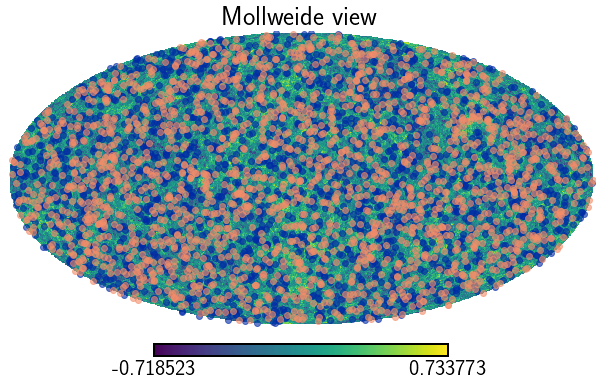

In [11]:
hp.mollview(density)
hp.projscatter(rand_tp[:,0], rand_tp[:,1],
               color = custom_cet[3], alpha = 0.6)
hp.projscatter(data_pos_2[:,0], data_pos_2[:,1],
               color = custom_cet[0],alpha = 0.6)


In [12]:
nrandoms = 100000
bins = np.logspace(-2.0,-1.0,40)
binx = np.zeros((len(bins),3))
binx[:,0] = np.logspace(-2.0,-1.0,40)
binx[:,1] = np.logspace(-1.6,-0.9,40)
binx[:,2] = np.logspace(-1.6,-0.9,40)
data = compute_cdf(data_pos, 3, nrandoms, binx)
data_2 = compute_cdf(data_pos_2, 3, nrandoms, binx)
data_r2 = compute_cdf(rand_tp, 3, nrandoms, binx)

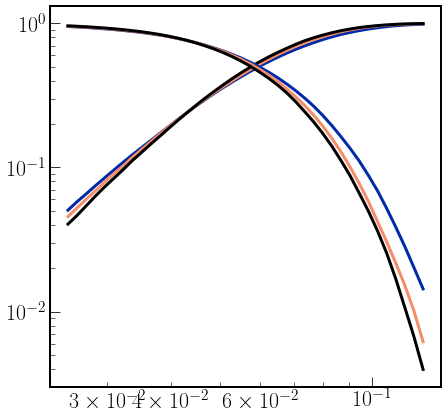

In [13]:
plt.plot(binx[:,1], data[:,1], lw = 3, c = custom_cet[3])
plt.plot(binx[:,1], data_2[:,1], lw = 3, c = custom_cet[0])

plt.plot(binx[:,1], data_r2[:,1], lw = 3, c = 'black')

plt.plot(binx[:,1], 1.0 - data[:,1], lw = 3, c = custom_cet[3])
plt.plot(binx[:,1], 1.0 - data_2[:,1], lw = 3, c = custom_cet[0])

plt.plot(binx[:,1], 1.0 - data_r2[:,1], lw = 3, c = 'black')
plt.xscale('log')
plt.yscale('log')

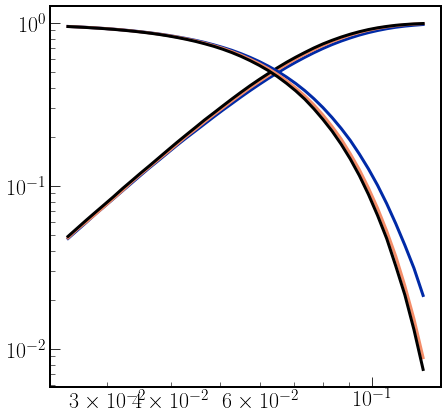

In [14]:
plt.plot(binx[:,1], data[:,0], lw = 3, c = custom_cet[3])
plt.plot(binx[:,1], data_2[:,0], lw = 3, c = custom_cet[0])

plt.plot(binx[:,1], data_r2[:,0], lw = 3, c = 'black')

plt.plot(binx[:,1], 1.0 - data[:,0], lw = 3, c = custom_cet[3])
plt.plot(binx[:,1], 1.0 - data_2[:,0], lw = 3, c = custom_cet[0])

plt.plot(binx[:,1], 1.0 - data_r2[:,0], lw = 3, c = 'black')
plt.xscale('log')
plt.yscale('log')

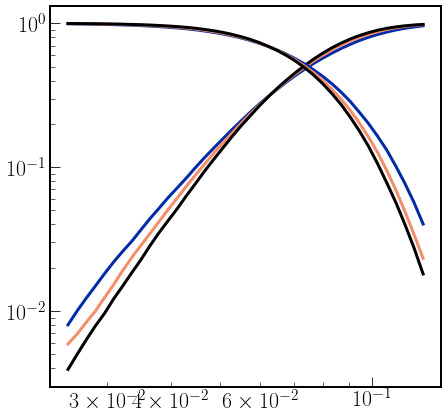

In [15]:
plt.plot(binx[:,1], data[:,2], lw = 3, c = custom_cet[3])
plt.plot(binx[:,1], data_2[:,2], lw = 3, c = custom_cet[0])

plt.plot(binx[:,1], data_r2[:,2], lw = 3, c = 'black')

plt.plot(binx[:,1], 1.0 - data[:,2], lw = 3, c = custom_cet[3])
plt.plot(binx[:,1], 1.0 - data_2[:,2], lw = 3, c = custom_cet[0])

plt.plot(binx[:,1], 1.0 - data_r2[:,2], lw = 3, c = 'black')
plt.xscale('log')
plt.yscale('log')

In [16]:
data_random = np.zeros((1000,len(bins)*3))

for i in range(1000):
    print (i)
    #pos2 = get_rand_theta_phi(npoints)
    pos2 = np.random.rand(npoints,2)
    pos2[:,0] = np.arccos(2*pos2[:,0]-1.0)
    pos2[:,1] *= 2*np.pi
    cdf = compute_cdf(pos2, 3, nrandoms, binx)
    data_random[i,:len(bins)] = cdf[:,0]
    data_random[i,len(bins):2*len(bins)] = cdf[:,1]
    data_random[i,2*len(bins):] = cdf[:, 2]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
mean_random = np.zeros(len(bins)*3)

for i in range(1000):
    mean_random += data_random[i,:]
    
    
mean_random /= 1000.
print (mean_random)

[0.04878315 0.05472182 0.06136589 0.06879468 0.0770784  0.08631901
 0.0965855  0.10800123 0.1206864  0.13474966 0.15030934 0.16749073
 0.18639978 0.20718933 0.22990634 0.25472493 0.28170301 0.31086823
 0.34230799 0.37595418 0.41175572 0.44959655 0.48928963 0.53054363
 0.57298513 0.61617195 0.65958989 0.7026159  0.7445927  0.78477151
 0.82250276 0.85712572 0.88806548 0.91494844 0.93755426 0.95588807
 0.97017899 0.98080433 0.98831846 0.99332569 0.04047025 0.04689576
 0.05428546 0.06272359 0.07234636 0.08329112 0.09573767 0.10978038
 0.12559386 0.1433179  0.1631377  0.18516033 0.20953199 0.2363207
 0.26559706 0.29736369 0.33159458 0.36823903 0.40706963 0.44791599
 0.49041484 0.53415929 0.5787328  0.62347223 0.66784002 0.71115356
 0.75273408 0.79192795 0.82813587 0.8609538  0.89003263 0.91513097
 0.93625731 0.95348668 0.9671474  0.97761008 0.98531504 0.99077153
 0.99447291 0.99684587 0.00413992 0.00520033 0.0065169  0.00815323
 0.01018573 0.01269239 0.01578689 0.01958023 0.02423072 0.02988

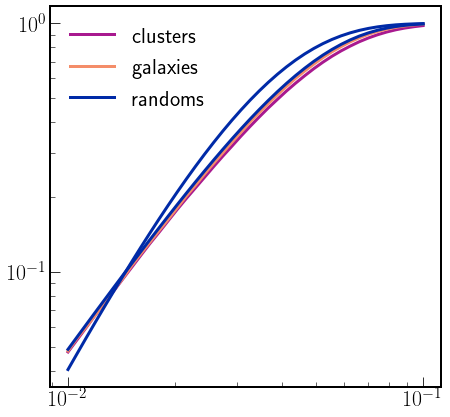

In [18]:
plt.plot(bins, data[:,0],lw = 3, c = custom_cet[2], label='clusters')
plt.plot(bins, data_2[:,0],lw = 3, c = custom_cet[0], label = 'galaxies')
plt.plot(bins, mean_random[:len(bins)], lw = 3, c=custom_cet[3], label = 'randoms')
plt.plot(bins, mean_random[len(bins):2*len(bins)], lw = 3, c=custom_cet[3], )



plt.xscale('log')
plt.yscale('log')
plt.legend()

In [19]:
data_reshape = np.zeros(len(bins)*3)
data_reshape[:len(bins)] = data[:,0]
data_reshape[len(bins):2*len(bins)] = data[:,1]
data_reshape[2*len(bins):] = data[:,2]


data2_reshape = np.zeros(len(bins)*3)
data2_reshape[:len(bins)] = data_2[:,0]
data2_reshape[len(bins):2*len(bins)] = data_2[:,1]
data2_reshape[2*len(bins):] = data_2[:,2]

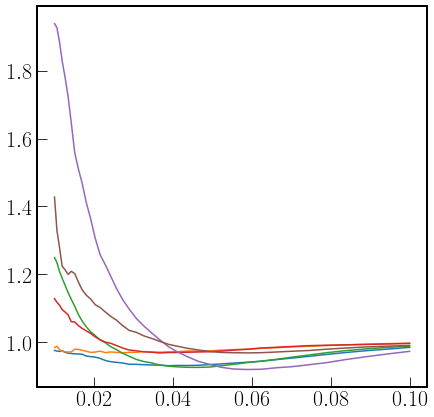

In [20]:
plt.plot(bins, data_reshape[:len(bins)]/mean_random[:len(bins)])

plt.plot(bins, data2_reshape[:len(bins)]/mean_random[:len(bins)])


plt.plot(bins, data_reshape[len(bins):2*len(bins)]/mean_random[len(bins):2*len(bins)])

plt.plot(bins, data2_reshape[len(bins):2*len(bins)]/mean_random[len(bins):2*len(bins)])

plt.plot(bins, data_reshape[2*len(bins):]/mean_random[2*len(bins):])

plt.plot(bins, data2_reshape[2*len(bins):]/mean_random[2*len(bins):])


In [21]:
cov_mat = np.zeros((len(bins)*3,len(bins)*3))
for i in range(1000):
    cov_mat += update_covmat(mean_random, data_random[i,:])
 
cov_mat /=1000.
diag = np.zeros(len(bins)*3)
for i in range(len(bins)*3):
    diag[i] = np.sqrt(cov_mat[i,i])



In [22]:
inv_covmat = np.linalg.inv(cov_mat)

In [23]:


T1 = np.dot(inv_covmat,(data_reshape-mean_random))
print (T1.shape)
T2 = np.dot(data_reshape-mean_random, T1)

data_chi2 = T2


T1 = np.dot(inv_covmat,(data2_reshape-mean_random))
print (T1.shape)
T2 = np.dot(data2_reshape-mean_random, T1)

data2_chi2 = T2

(120,)
(120,)


In [24]:
rand_chi2 = np.zeros(1000)

for i in range(1000):
    T1 = np.dot(inv_covmat,(data_random[i]-mean_random))
    T2 = np.dot(data_random[i]-mean_random, T1)
    rand_chi2[i] = T2

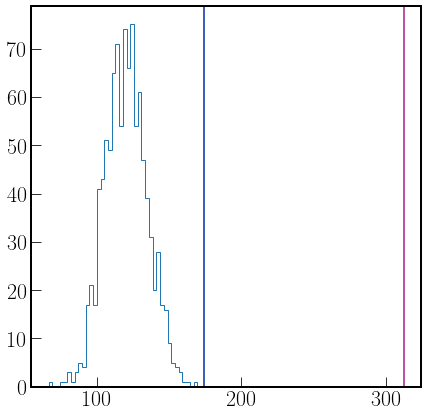

In [25]:
plt.hist(rand_chi2,40, histtype="step")
plt.axvline(data_chi2, c = custom_cet[2])
plt.axvline(data2_chi2, c = custom_cet[3])